## Most Basic Graph Neural Network with Gaussian Filter on MNIST


Implementing a very basic graph neural network (GNN) using a Gaussian filter.

Here, the 28x28 image of a digit in MNIST represents the graph, where each pixel (i.e., cell in the grid) represents a particular node. The feature of that node is simply the pixel intensity in rang


 https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/gnn/gnn-basic-1.ipynbhttps://github.com/bknyaz/examples/blob/42eb912a6b95be77e19b6011866a189e70f74666/fc_vs_graph_train.py#L127

Here, the adjacency matrix of the pixels is basically just determined by their neighborhood pixels. Using a Gaussian filter, we connect pixels based on their Euclidean distance in the grid.


Using this adjacency matrix $A$, we can compute the output of a layer as

$$ X^{(l+1)} = A X^{(l)} W^{(l)}$$

Here, $A$ is the $N \times N$ adj. matrix and $X$ is the $N \times C$ featue matrix

In [13]:

import time
import numpy as np
from scipy.spatial.distance import cdist
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt


In [15]:
##########################
### SETTINGS
##########################

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.05
NUM_EPOCHS = 5
BATCH_SIZE = 128
IMG_SIZE = 28

# Architecture
NUM_CLASSES = 10

In [17]:
train_indices = torch.arange(0, 59000)
valid_indices = torch.arange(59000, 60000)

custom_transform = transforms.Compose([transforms.ToTensor()])


train_and_valid = datasets.MNIST(root='data', 
                                 train=True, 
                                 transform=custom_transform,
                                 download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=custom_transform,
                              download=True)

train_dataset = Subset(train_and_valid, train_indices)
valid_dataset = Subset(train_and_valid, valid_indices)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [26]:
asd = datasets.MNIST(root='data', train=True,download=True)

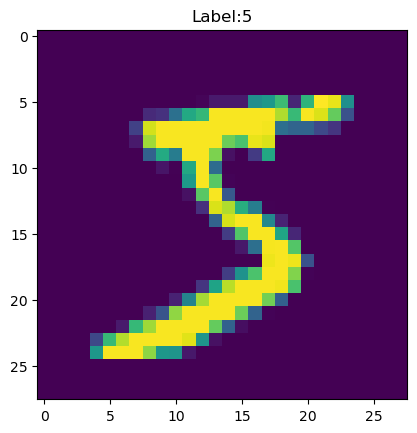

In [36]:
for i in asd:
    img,c=i
    plt.title(f'Label:{c}')
    plt.imshow(img)
    plt.show()
    break

In [18]:

def precompute_adjacency_matrix(img_size):
    col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
    
    # N = img_size^2
    # construct 2D coordinate array (shape N x 2) and normalize
    # in range [0, 1]
    coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size

    # compute pairwise distance matrix (N x N)
    dist = cdist(coord, coord, metric='euclidean')
    
    # Apply Gaussian filter
    sigma = 0.05 * np.pi
    A = np.exp(- dist / sigma ** 2)
    A[A < 0.01] = 0
    A = torch.from_numpy(A).float()

    # Normalization as per (Kipf & Welling, ICLR 2017)
    D = A.sum(1)  # nodes degree (N,)
    D_hat = (D + 1e-5) ** (-0.5)
    A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1)  # N,N
    
    return A_hat

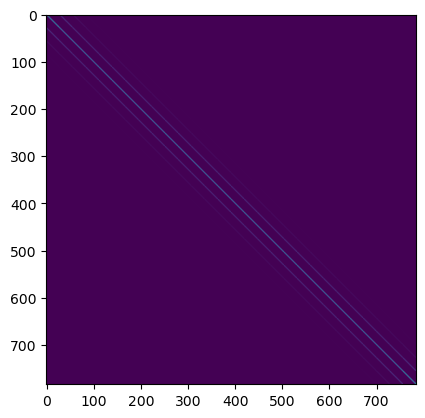

In [19]:
plt.imshow(precompute_adjacency_matrix(28));

In [20]:
precompute_adjacency_matrix(2)

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000]])

In [7]:
##########################
### MODEL
##########################

        

class GraphNet(nn.Module):
    def __init__(self, img_size=28, num_classes=10):
        super(GraphNet, self).__init__()
        
        n_rows = img_size**2
        self.fc = nn.Linear(n_rows, num_classes, bias=False)

        A = precompute_adjacency_matrix(img_size)
        self.register_buffer('A', A)

        

    def forward(self, x):
        
        B = x.size(0) # Batch size

        ### Reshape Adjacency Matrix
        # [N, N] Adj. matrix -> [1, N, N] Adj tensor where N = HxW
        A_tensor = self.A.unsqueeze(0)
        # [1, N, N] Adj tensor -> [B, N, N] tensor
        A_tensor = self.A.expand(B, -1, -1)
        
        ### Reshape inputs
        # [B, C, H, W] => [B, H*W, 1]
        x_reshape = x.view(B, -1, 1)
        
        # bmm = batch matrix product to sum the neighbor features
        # Input: [B, N, N] x [B, N, 1]
        # Output: [B, N]
        avg_neighbor_features = (torch.bmm(A_tensor, x_reshape).view(B, -1))
        
        logits = self.fc(avg_neighbor_features)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [8]:
torch.manual_seed(RANDOM_SEED)
model = GraphNet(img_size=IMG_SIZE, num_classes=NUM_CLASSES)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [9]:

def compute_acc(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()

cost_list = []
train_acc_list, valid_acc_list = [], []


for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        #################################################
        ### CODE ONLY FOR LOGGING BEYOND THIS POINT
        ################################################
        cost_list.append(cost.item())
        if not batch_idx % 150:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        
        train_acc = compute_acc(model, train_loader, device=DEVICE)
        valid_acc = compute_acc(model, valid_loader, device=DEVICE)
        
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train ACC: {train_acc:.2f} | Validation ACC: {valid_acc:.2f}')
        
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')

elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/005 | Batch 000/461 | Cost: 2.2449
Epoch: 001/005 | Batch 150/461 | Cost: 0.8476
Epoch: 001/005 | Batch 300/461 | Cost: 0.5709
Epoch: 001/005 | Batch 450/461 | Cost: 0.5937
Epoch: 001/005
Train ACC: 86.90 | Validation ACC: 92.10
Time elapsed: 0.32 min
Epoch: 002/005 | Batch 000/461 | Cost: 0.5034
Epoch: 002/005 | Batch 150/461 | Cost: 0.4132
Epoch: 002/005 | Batch 300/461 | Cost: 0.4706
Epoch: 002/005 | Batch 450/461 | Cost: 0.3690
Epoch: 002/005
Train ACC: 88.33 | Validation ACC: 92.60
Time elapsed: 0.66 min
Epoch: 003/005 | Batch 000/461 | Cost: 0.4121
Epoch: 003/005 | Batch 150/461 | Cost: 0.4513
Epoch: 003/005 | Batch 300/461 | Cost: 0.4056
Epoch: 003/005 | Batch 450/461 | Cost: 0.2735
Epoch: 003/005
Train ACC: 88.94 | Validation ACC: 93.20
Time elapsed: 0.99 min
Epoch: 004/005 | Batch 000/461 | Cost: 0.4208
Epoch: 004/005 | Batch 150/461 | Cost: 0.4065
Epoch: 004/005 | Batch 300/461 | Cost: 0.3819
Epoch: 004/005 | Batch 450/461 | Cost: 0.2904
Epoch: 004/005
Train ACC: 8

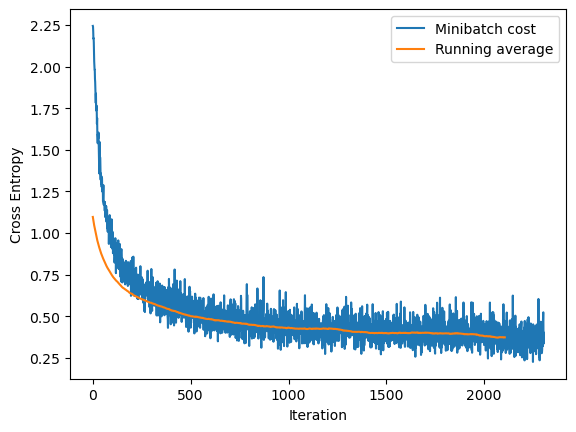

In [10]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

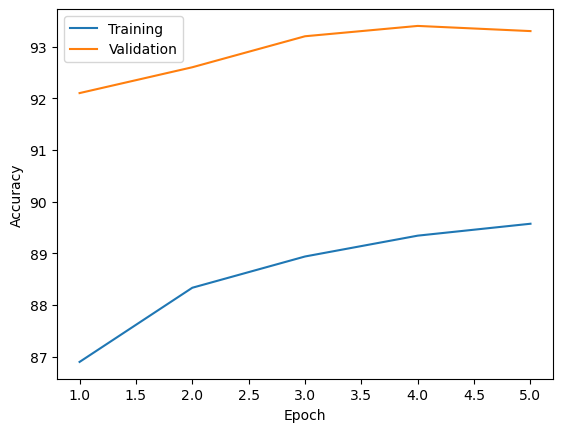

In [11]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
with torch.set_grad_enabled(False):
    test_acc = compute_acc(model=model,
                           data_loader=test_loader,
                           device=DEVICE)
    
    valid_acc = compute_acc(model=model,
                            data_loader=valid_loader,
                            device=DEVICE)
    

print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Validation ACC: 93.30%
Test ACC: 90.44%


### Basic Graph Neural Network with Edge Prediction on MNIST

In [37]:
def make_coordinate_array(img_size, out_size=4):
    
    ### Make 2D coordinate array (for MNIST: 784x2)
    n_rows = img_size * img_size
    col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
    coord = np.stack((col, row), axis=2).reshape(-1, 2)
    coord = (coord - np.mean(coord, axis=0)) / (np.std(coord, axis=0) + 1e-5)
    coord = torch.from_numpy(coord).float()
    
    ### Reshape to [N, N, out_size]
    coord = torch.cat((coord.unsqueeze(0).repeat(n_rows, 1,  int(out_size/2-1)),
                            coord.unsqueeze(1).repeat(1, n_rows, 1)), dim=2)
    
    
    return coord

        

class GraphNet(nn.Module):
    def __init__(self, img_size=28, coord_features=4, num_classes=10):
        super(GraphNet, self).__init__()
        
        n_rows = img_size**2
        self.fc = nn.Linear(n_rows, num_classes, bias=False)

        coord = make_coordinate_array(img_size, coord_features)
        self.register_buffer('coord', coord)
        
        ##########
        # Edge Predictor
        self.pred_edge_fc = nn.Sequential(nn.Linear(coord_features, 32), # coord -> hidden
                                          nn.ReLU(),
                                          nn.Linear(32, 1), # hidden -> edge
                                          nn.Tanh())
        

        

    def forward(self, x):
        B = x.size(0)
        
        ### Predict edges
        self.A = self.pred_edge_fc(self.coord).squeeze()

        ### Reshape Adjacency Matrix
        # [N, N] Adj. matrix -> [1, N, N] Adj tensor where N = HxW
        A_tensor = self.A.unsqueeze(0)
        # [1, N, N] Adj tensor -> [B, N, N] tensor
        A_tensor = self.A.expand(B, -1, -1)
        
        ### Reshape inputs
        # [B, C, H, W] => [B, H*W, 1]
        x_reshape = x.view(B, -1, 1)
        
        # bmm = batch matrix product to sum the neighbor features
        # Input: [B, N, N] x [B, N, 1]
        # Output: [B, N]
        avg_neighbor_features = (torch.bmm(A_tensor, x_reshape).view(B, -1))

        logits = self.fc(avg_neighbor_features)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [38]:

torch.manual_seed(RANDOM_SEED)
model = GraphNet(img_size=IMG_SIZE, num_classes=NUM_CLASSES)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [39]:

def compute_acc(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()

cost_list = []
train_acc_list, valid_acc_list = [], []


for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        #################################################
        ### CODE ONLY FOR LOGGING BEYOND THIS POINT
        ################################################
        cost_list.append(cost.item())
        if not batch_idx % 150:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        
        train_acc = compute_acc(model, train_loader, device=DEVICE)
        valid_acc = compute_acc(model, valid_loader, device=DEVICE)
        
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train ACC: {train_acc:.2f} | Validation ACC: {valid_acc:.2f}')
        
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/005 | Batch 000/461 | Cost: 28.7652
Epoch: 001/005 | Batch 150/461 | Cost: 2.2893
Epoch: 001/005 | Batch 300/461 | Cost: 1.7929
Epoch: 001/005 | Batch 450/461 | Cost: 1.5215
Epoch: 001/005
Train ACC: 31.52 | Validation ACC: 29.30
Time elapsed: 2.32 min
Epoch: 002/005 | Batch 000/461 | Cost: 1.9673
Epoch: 002/005 | Batch 150/461 | Cost: 1.1896
Epoch: 002/005 | Batch 300/461 | Cost: 1.2194
Epoch: 002/005 | Batch 450/461 | Cost: 1.2713
Epoch: 002/005
Train ACC: 64.70 | Validation ACC: 70.90
Time elapsed: 4.70 min
Epoch: 003/005 | Batch 000/461 | Cost: 1.0207
Epoch: 003/005 | Batch 150/461 | Cost: 1.5535
Epoch: 003/005 | Batch 300/461 | Cost: 0.9305
Epoch: 003/005 | Batch 450/461 | Cost: 0.7736
Epoch: 003/005
Train ACC: 76.62 | Validation ACC: 81.30
Time elapsed: 6.79 min
Epoch: 004/005 | Batch 000/461 | Cost: 0.7963
Epoch: 004/005 | Batch 150/461 | Cost: 0.9648
Epoch: 004/005 | Batch 300/461 | Cost: 0.8028
Epoch: 004/005 | Batch 450/461 | Cost: 0.7517
Epoch: 004/005
Train ACC: 

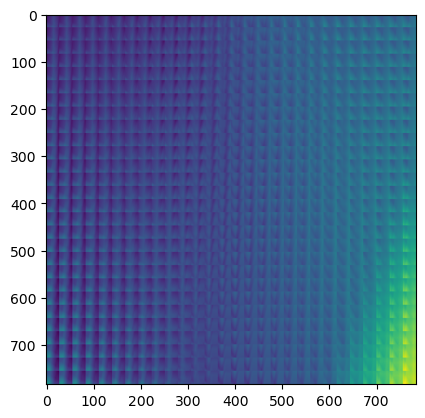

In [40]:
# last adjacency matrix

plt.imshow(model.A.to('cpu'));

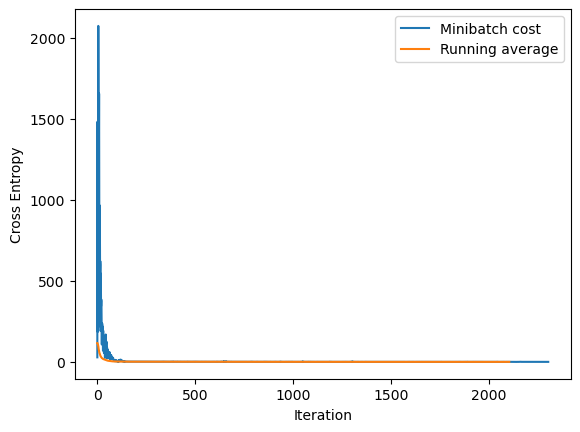

In [41]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

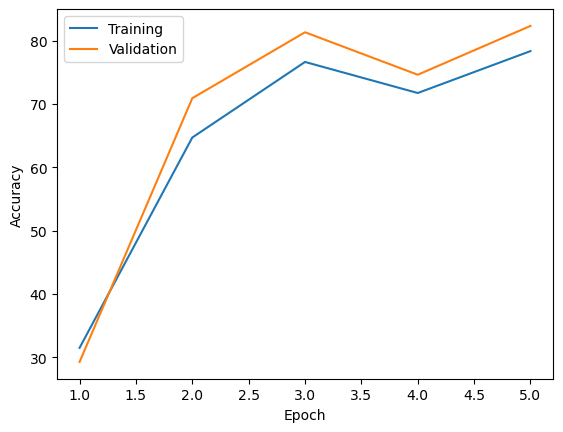

In [42]:

plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [43]:

with torch.set_grad_enabled(False):
    test_acc = compute_acc(model=model,
                           data_loader=test_loader,
                           device=DEVICE)
    
    valid_acc = compute_acc(model=model,
                            data_loader=valid_loader,
                            device=DEVICE)
    

print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Validation ACC: 82.30%
Test ACC: 79.03%



## Basic Graph Neural Network with Spectral Graph Convolution on MNIST

Implementing a very basic graph neural network (GNN) using a spectral graph convolution.


Here, the 28x28 image of a digit in MNIST represents the graph, where each pixel (i.e., cell in the grid) represents a particular node. The feature of that node is simply the pixel intensity in range [0, 1].

Here, the adjacency matrix of the pixels is basically just determined by their neighborhood pixels. Using a Gaussian filter, we connect pixels based on their Euclidean distance in the grid.

In [44]:
import time
import numpy as np
from scipy.spatial.distance import cdist
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

In [46]:
def precompute_adjacency_matrix(img_size):
    col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
    
    # N = img_size^2
    # construct 2D coordinate array (shape N x 2) and normalize
    # in range [0, 1]
    coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size

    # compute pairwise distance matrix (N x N)
    dist = cdist(coord, coord, metric='euclidean')
    
    # Apply Gaussian filter
    sigma = 0.05 * np.pi
    A = np.exp(- dist / sigma ** 2)
    A[A < 0.01] = 0
    A = torch.from_numpy(A).float()
    
    return A

    """
    # Normalization as per (Kipf & Welling, ICLR 2017)
    D = A.sum(1)  # nodes degree (N,)
    D_hat = (D + 1e-5) ** (-0.5)
    A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1)  # N,N
    
    return A_hat
    """


def get_graph_laplacian(A):
    # From https://towardsdatascience.com/spectral-graph-convolution-
    #   explained-and-implemented-step-by-step-2e495b57f801
    #
    # Computing the graph Laplacian
    # A is an adjacency matrix of some graph G
    N = A.shape[0] # number of nodes in a graph
    D = np.sum(A, 0) # node degrees
    D_hat = np.diag((D + 1e-5)**(-0.5)) # normalized node degrees
    L = np.identity(N) - np.dot(D_hat, A).dot(D_hat) # Laplacian
    return torch.from_numpy(L).float()

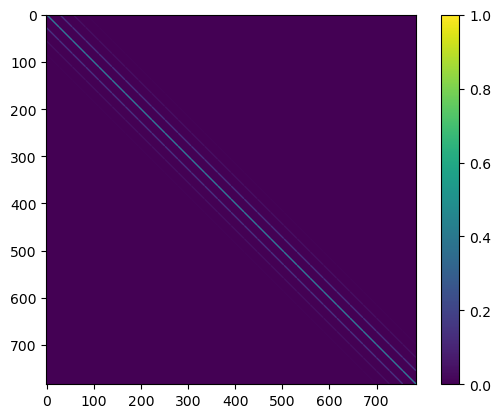

In [47]:
A = precompute_adjacency_matrix(28)
plt.imshow(A, vmin=0., vmax=1.)
plt.colorbar()
plt.show()

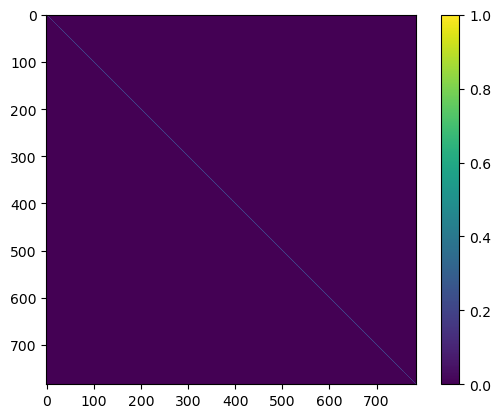

In [48]:

L = get_graph_laplacian(A.numpy())
plt.imshow(L, vmin=0., vmax=1.)
plt.colorbar()
plt.show()

In [49]:
from scipy.sparse.linalg import eigsh
        

class GraphNet(nn.Module):
    def __init__(self, img_size=28, num_filters=2, num_classes=10):
        super(GraphNet, self).__init__()
        
        n_rows = img_size**2
        self.fc = nn.Linear(n_rows*num_filters, num_classes, bias=False)

        A = precompute_adjacency_matrix(img_size)
        L = get_graph_laplacian(A.numpy())
        Λ,V = eigsh(L.numpy(), k=20, which='SM') # eigen-decomposition (i.e. find Λ,V)

        V = torch.from_numpy(V)
        
        # Weight matrix
        W_spectral = nn.Parameter(torch.ones((img_size**2, num_filters))).float()
        torch.nn.init.kaiming_uniform_(W_spectral)
        
        self.register_buffer('A', A)
        self.register_buffer('L', L)
        self.register_buffer('V', V)
        self.register_buffer('W_spectral', W_spectral)

        

    def forward(self, x):
        
        B = x.size(0) # Batch size

        ### Reshape eigenvectors
        # from [H*W, 20] to [B, H*W, 20]
        V_tensor = self.V.unsqueeze(0)
        V_tensor = self.V.expand(B, -1, -1)
        # from [H*W, 20] to [B, 20, H*W]
        V_tensor_T = self.V.T.unsqueeze(0)
        V_tensor_T = self.V.T.expand(B, -1, -1)
        
        ### Reshape inputs
        # [B, C, H, W] => [B, H*W, 1]
        x_reshape = x.view(B, -1, 1)
        
        ### Reshape spectral weights
        # to size [128, H*W, F]
        W_spectral_tensor = self.W_spectral.unsqueeze(0)
        W_spectral_tensor = self.W_spectral.expand(B, -1, -1)
        
        ### Spectral convolution on graphs
        # [B, 20, H*W] . [B, H*W, 1]  ==> [B, 20, 1]
        X_hat = V_tensor_T.bmm(x_reshape) # 20×1 node features in the "spectral" domain
        W_hat = V_tensor_T.bmm(W_spectral_tensor)  # 20×F filters in the "spectral" domain
        Y = V_tensor.bmm(X_hat * W_hat)  # N×F result of convolution

        ### Fully connected
        logits = self.fc(Y.reshape(B, -1))
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [50]:
torch.manual_seed(RANDOM_SEED)
model = GraphNet(img_size=IMG_SIZE, num_classes=NUM_CLASSES)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [51]:

def compute_acc(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()

cost_list = []
train_acc_list, valid_acc_list = [], []


for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        #################################################
        ### CODE ONLY FOR LOGGING BEYOND THIS POINT
        ################################################
        cost_list.append(cost.item())
        if not batch_idx % 150:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        
        train_acc = compute_acc(model, train_loader, device=DEVICE)
        valid_acc = compute_acc(model, valid_loader, device=DEVICE)
        
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train ACC: {train_acc:.2f} | Validation ACC: {valid_acc:.2f}')
        
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')

elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/005 | Batch 000/461 | Cost: 2.3069
Epoch: 001/005 | Batch 150/461 | Cost: 1.2208
Epoch: 001/005 | Batch 300/461 | Cost: 0.9906
Epoch: 001/005 | Batch 450/461 | Cost: 0.8745
Epoch: 001/005
Train ACC: 75.61 | Validation ACC: 80.50
Time elapsed: 0.11 min
Epoch: 002/005 | Batch 000/461 | Cost: 0.8857
Epoch: 002/005 | Batch 150/461 | Cost: 0.7932
Epoch: 002/005 | Batch 300/461 | Cost: 0.6475
Epoch: 002/005 | Batch 450/461 | Cost: 0.8662
Epoch: 002/005
Train ACC: 77.30 | Validation ACC: 81.40
Time elapsed: 0.22 min
Epoch: 003/005 | Batch 000/461 | Cost: 0.8391
Epoch: 003/005 | Batch 150/461 | Cost: 0.8345
Epoch: 003/005 | Batch 300/461 | Cost: 1.0825
Epoch: 003/005 | Batch 450/461 | Cost: 0.8953
Epoch: 003/005
Train ACC: 78.44 | Validation ACC: 82.60
Time elapsed: 0.34 min
Epoch: 004/005 | Batch 000/461 | Cost: 0.7139
Epoch: 004/005 | Batch 150/461 | Cost: 0.6563
Epoch: 004/005 | Batch 300/461 | Cost: 0.7655
Epoch: 004/005 | Batch 450/461 | Cost: 0.8473
Epoch: 004/005
Train ACC: 7

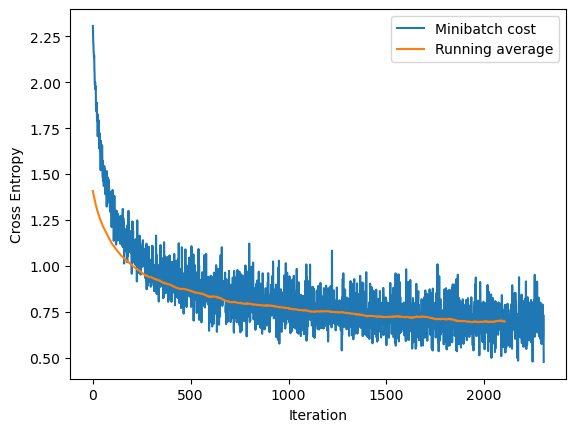

In [52]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

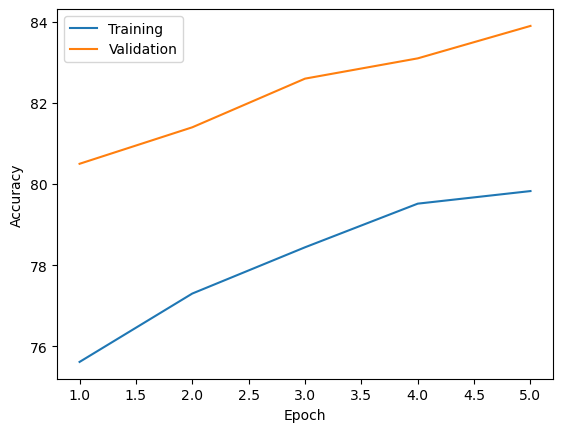

In [53]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [54]:
with torch.set_grad_enabled(False):
    test_acc = compute_acc(model=model,
                           data_loader=test_loader,
                           device=DEVICE)
    
    valid_acc = compute_acc(model=model,
                            data_loader=valid_loader,
                            device=DEVICE)
    

print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Validation ACC: 83.90%
Test ACC: 80.98%
